## Data Pre-Processing and Feature Engineering

From the EDA some information related to the nature of the data was gather, such as:

- The presence of missing values in the actual times.  
actual_start_time_picking: 23378  
actual_end_time_picking: 37408

- No duplicates where found.

- There are extreme values (outliers) that could significantly skew the analysis.

## 1. Import Data and Required Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

os.chdir("../")
%pwd

'c:\\Users\\anfe1\\OneDrive\\Escritorio\\Instaleap\\Instamarket'

#### Import the CSV Data as Pandas DataFrame

In [3]:
df = pd.read_csv('artifacts/data.csv')

# Converting time_picking's to datetime DType
datetime_cols = ["actual_start_time_picking",
                 "actual_end_time_picking",
                 "optimal_start_time_picking",
                 "optimal_end_time_picking"]
df[datetime_cols] = df[datetime_cols].apply(pd.to_datetime, format="mixed")


As the "job_id" column is just a label for the order could be dropped as it does not give any additonal information

In [4]:
df.drop(columns="job_id", axis=1, inplace=True)

## 2. Actions to perform

- Handling missing values
- Handling outliers

### 2.1 Handling Missing values

In [5]:
df.isna().sum()

store_id                          0
actual_start_time_picking     23378
actual_end_time_picking       37408
optimal_start_time_picking        0
optimal_end_time_picking          0
dtype: int64

In [6]:
print(df["actual_start_time_picking"].isna().sum()/df.shape[0]*100)
print(df["actual_end_time_picking"].isna().sum()/df.shape[0]*100)

# print(df[~df["actual_start_time_picking"].isna() & df["actual_end_time_picking"].isna()].shape[0]/df.shape[0]*100)

6.933964502657555
11.095292331055429


At first I will remove the rows with missing values assuming there where cancelled orders.

In [7]:
df.dropna(subset=['actual_start_time_picking', 'actual_end_time_picking'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299744 entries, 0 to 299743
Data columns (total 5 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   store_id                    299744 non-null  object             
 1   actual_start_time_picking   299744 non-null  datetime64[ns, UTC]
 2   actual_end_time_picking     299744 non-null  datetime64[ns, UTC]
 3   optimal_start_time_picking  299744 non-null  datetime64[ns, UTC]
 4   optimal_end_time_picking    299744 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](4), object(1)
memory usage: 11.4+ MB


So, there reamins 299744 rows to work with. It's still very good amount of data representing the 88.9% of the original data.

### 2.2 Adding columns for analysis 

Time analysis columns
- actual_total_time
- optimal_total_time

Efficiency analysis columns
- start_delay
- end_delay
- PTP (Picking Time Percentage)

In [8]:
time_analysis_cols = ["actual_total_time",
                      "optimal_total_time",
                      "diff_actual_optimal_time"]

efficiency_cols = ["start_delay",
                   "end_delay",
                   "PTP"]

df["actual_total_time"] = (df["actual_end_time_picking"] - df["actual_start_time_picking"]).dt.total_seconds() / 60.0
df["optimal_total_time"] = (df["optimal_end_time_picking"] - df["optimal_start_time_picking"]).dt.total_seconds() / 60.0
df["diff_actual_optimal_time"] = df["actual_total_time"] - df["optimal_total_time"]

df["start_delay"] = (df["actual_start_time_picking"] - df["optimal_start_time_picking"]).dt.total_seconds() / 60.0
df["end_delay"] = (df["actual_end_time_picking"] - df["optimal_end_time_picking"]).dt.total_seconds() / 60.0

df["PTP"] = df["actual_total_time"]/df["optimal_total_time"]

df.count()

store_id                      299744
actual_start_time_picking     299744
actual_end_time_picking       299744
optimal_start_time_picking    299744
optimal_end_time_picking      299744
actual_total_time             299744
optimal_total_time            299744
diff_actual_optimal_time      299744
start_delay                   299744
end_delay                     299744
PTP                           299744
dtype: int64

### 2.3 Handling Outliers

From the EDA it was seen some extreme values that could significantly skew the results.  
Z-score will be used. Scores beyond the threshold (-3,3) will be identified as outliers.  
  
On first intance the outliers will be removed.

In [9]:
cols_to_normalize = [*time_analysis_cols,*efficiency_cols]

for col in cols_to_normalize:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)

In [10]:
# zcore_cols  =  [col+ '_zscore' for col in ["actual_total_time","diff_actual_optimal_time",*efficiency_cols]]
zcore_cols  =  [col+ '_zscore' for col in cols_to_normalize]
filters = [(df[col]>-3) & (df[col]<3) for col in zcore_cols]

df_clean = df[np.logical_and.reduce(filters)]

In [11]:
df_clean.nunique()

store_id                              740
actual_start_time_picking          236020
actual_end_time_picking            288638
optimal_start_time_picking          11912
optimal_end_time_picking            11731
actual_total_time                  279599
optimal_total_time                     98
diff_actual_optimal_time           284122
start_delay                        219161
end_delay                          283379
PTP                                286024
actual_total_time_zscore           279599
optimal_total_time_zscore              98
diff_actual_optimal_time_zscore    282082
start_delay_zscore                 219161
end_delay_zscore                   283379
PTP_zscore                         285457
dtype: int64

In [12]:
df_clean.drop(columns=["actual_total_time","diff_actual_optimal_time","PTP",*zcore_cols], inplace=True)

In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288715 entries, 0 to 299743
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   store_id                    288715 non-null  object             
 1   actual_start_time_picking   288715 non-null  datetime64[ns, UTC]
 2   actual_end_time_picking     288715 non-null  datetime64[ns, UTC]
 3   optimal_start_time_picking  288715 non-null  datetime64[ns, UTC]
 4   optimal_end_time_picking    288715 non-null  datetime64[ns, UTC]
 5   optimal_total_time          288715 non-null  float64            
 6   start_delay                 288715 non-null  float64            
 7   end_delay                   288715 non-null  float64            
dtypes: datetime64[ns, UTC](4), float64(3), object(1)
memory usage: 19.8+ MB


In [20]:
stores = df_clean["store_id"].unique()
list(stores)
# df_clean.to_csv("artifacts/data_clean.csv", index=False, header=True)

['732eec9f-fc84-4d20-86b9-fe357a0976bb',
 '115ee3df-80e2-4c17-a5e9-29bcae08fe01',
 '6a54da8e-9ba7-4f0a-a143-d7711eb6b5e7',
 'ab0c60c6-1935-4f1d-a80a-25d0e9e8fbb7',
 '3f298c0f-d807-4d26-9908-8c3f3f2b369a',
 'b37369cc-9a55-4d73-9f62-a15892b4e3a1',
 '09c02529-8a8a-498b-8bcd-422a7f5cbe83',
 'f6da8109-e12d-4565-832a-beca657b17d2',
 '2e53f7f3-27d6-4c81-b4fd-3a070bb11c63',
 '8c7901f2-4ef1-4694-83cb-3f54be928572',
 '0c1a31af-e3f3-4bc6-b526-0cecabd3be40',
 '0fa808bc-9e24-4195-9e53-c0a76a480d04',
 '2afff6b6-c764-456c-9c9d-1879b32764d8',
 'd1341f9f-44f8-4864-a68e-7f24bd953aaa',
 '884a7856-f95a-47aa-b20c-2652c862ec00',
 'eb67d81d-c32f-4a8f-bebe-b13fb4b8f687',
 '6cda12c4-1001-4b66-9477-60cc0a946745',
 '512bc0a9-5775-4ee2-8ef7-b91f8d8e982e',
 'c85b0844-b4f0-4187-b335-33bbf7459ead',
 'd2ed6263-7847-427a-9e3f-09d98640000f',
 'd7d8f1a6-e65c-4b00-addf-8ba138e27945',
 '0a7db3f4-a908-4697-9a9a-0fa6611014cb',
 'd22abb86-dace-4bdd-ad74-0d0c616c5d59',
 '65dec8a5-ac57-4bfd-8d1a-378c22b24614',
 'ce185e60-b358-

## 3. Visualizing pre-process data

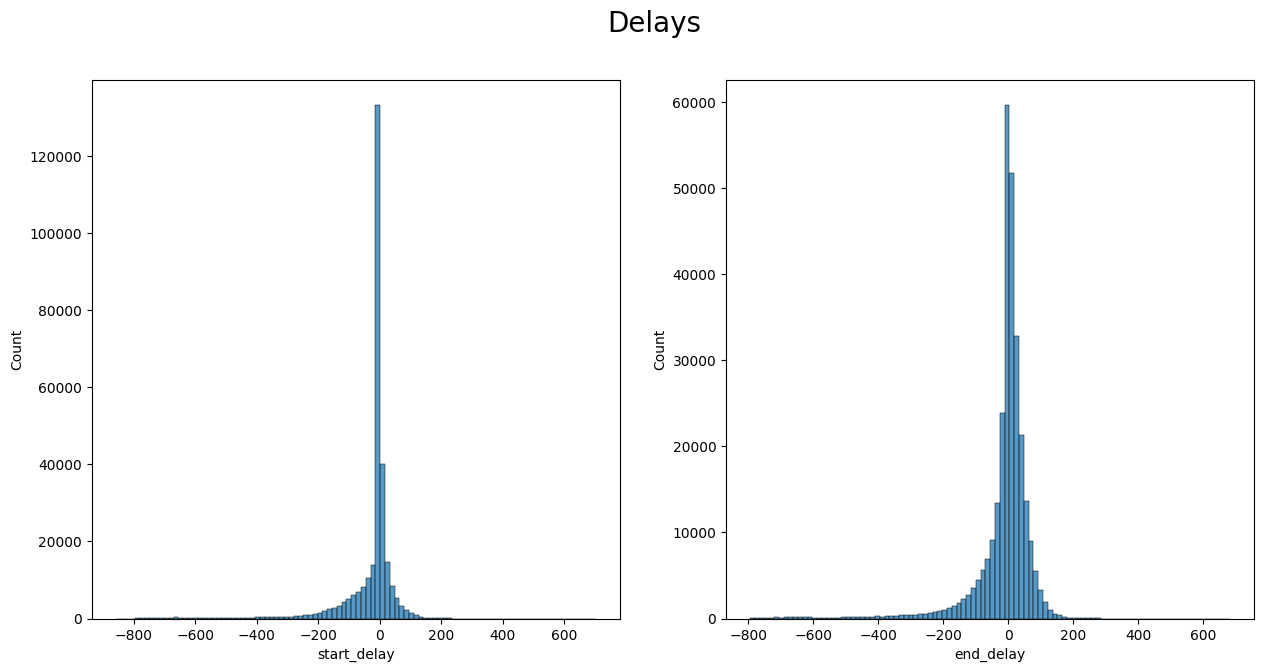

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sb.histplot(data=df_clean,x='start_delay', bins=100)
plt.subplot(122)
sb.histplot(data=df_clean,x='end_delay', bins=100)
fig.suptitle("Delays", fontsize=20)
plt.show()

## 4. Preparing dataframe for model training

In [ ]:
df = pd.read_csv("artifacts/data_preprocessing/clean_data.csv")

datetime_cols = ["optimal_start_time_picking",
                 "optimal_end_time_picking"]
df[datetime_cols] = df[datetime_cols].apply(pd.to_datetime)

df_prepared = df[["store_id","optimal_total_time","start_delay","end_delay"]]

df_prepared['optimal_start_day'] = df['optimal_start_time_picking'].dt.day
df_prepared['optimal_start_hour'] = df['optimal_start_time_picking'].dt.hour
df_prepared['optimal_start_minute'] = df['optimal_start_time_picking'].dt.minute
df_prepared['optimal_start_weekday'] = df['optimal_start_time_picking'].dt.weekday
df_prepared['optimal_start_is_weekend'] = df_prepared['optimal_start_weekday'].isin([5, 6])

df_prepared['optimal_end_day'] = df['optimal_end_time_picking'].dt.day
df_prepared['optimal_end_hour'] = df['optimal_end_time_picking'].dt.hour
df_prepared['optimal_end_minute'] = df['optimal_end_time_picking'].dt.minute
df_prepared['optimal_end_weekday'] = df['optimal_end_time_picking'].dt.weekday
df_prepared['optimal_end_is_weekend'] = df_prepared['optimal_end_weekday'].isin([5, 6])

df_prepared

,store_id,optimal_total_time,start_delay,end_delay,optimal_start_day,optimal_start_hour,optimal_start_minute,optimal_start_weekday,optimal_start_is_weekend,optimal_end_day,optimal_end_hour,optimal_end_minute,optimal_end_weekday,optimal_end_is_weekend
0,732eec9f-fc84-4d20-86b9-fe357a0976bb,5.0,-71.064283,-75.795017,5,21,3,1,False,5,21,8,1,False
1,115ee3df-80e2-4c17-a5e9-29bcae08fe01,4.0,0.006067,20.919233,4,23,28,0,False,4,23,32,0,False
2,6a54da8e-9ba7-4f0a-a143-d7711eb6b5e7,39.0,-4.419133,186.731600,4,23,29,0,False,5,0,8,1,False
3,ab0c60c6-1935-4f1d-a80a-25d0e9e8fbb7,3.0,-4.919950,12.860133,5,0,42,1,False,5,0,45,1,False
4,3f298c0f-d807-4d26-9908-8c3f3f2b369a,2.0,-4.322983,-1.242117,5,1,4,1,False,5,1,6,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288710,43ccc4f4-771b-4b61-a93b-195a54eec76f,42.0,-39.549483,-50.841133,2,16,30,5,True,2,17,12,5,True
288711,43ccc4f4-771b-4b61-a93b-195a54eec76f,57.0,21.015600,1.456183,1,23,20,4,False,2,0,17,5,True
288712,43ccc4f4-771b-4b61-a93b-195a54eec76f,15.0,-46.275333,-34.138267,2,18,2,5,True,2,18,17,5,True
288713,43ccc4f4-771b-4b61-a93b-195a54eec76f,45.0,-117.085167,-74.969950,2,21,11,5,True,2,21,56,5,True
